In [119]:
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import arviz as az

%matplotlib inline

In [120]:
osha = pd.read_csv('../data/osha/osha_norm_naics.csv', dtype={'naics_code':str, 'sic_code':str},
                  na_values = ["", " ","NaN", "nan", "NA", "na", "Na"])
osha = osha[['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name', 'subsector_name',
             'industry_group_name', 'conc_mgm3']]  # keep only cols we need
osha = osha[~osha['sector_name'].isin(["Undefined/Multiple"])]
osha = osha.drop(osha[osha['conc_mgm3']>10000].index)
osha = osha.dropna(subset=['conc_mgm3', 'sector_name'])
osha['sector_enc'] = osha['sector_name'].astype('category').cat.codes
osha['subsector_enc'] = osha['subsector_name'].astype('category').cat.codes
osha['industry_group_enc'] = osha['industry_group_name'].astype('category').cat.codes
osha['detected'] = np.where(osha['conc_mgm3'] > 0, 1, 0)

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (0,7,11,20,29,31) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [121]:
osha = osha.groupby(['inspection_number', 'establishment_name', 'preferred_name','naics_unified', 'sector_name',
                     'subsector_name', 'industry_group_name', 'sector_enc', 'subsector_enc', 'industry_group_enc'], as_index=False).max()
osha.head(10)

,inspection_number,establishment_name,preferred_name,naics_unified,sector_name,subsector_name,industry_group_name,sector_enc,subsector_enc,industry_group_enc,conc_mgm3,detected
0,29067,"GARMAT USA, INC.",Iron oxide,332322,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,1.959734,1
1,29206,Polar Corporation,Iron oxide,811310,Other Services,Repair and Maintenance,Commercial and Industrial Machinery and Equipm...,12,76,49,12.966245,1
2,29251,"Jobsite, Inc.",Iron oxide,333517,Manufacturing,Machinery Manufacturing,Metalworking Machinery Manufacturing,10,44,150,0.519814,1
3,29479,"TIC, The Industrial Company",Iron oxide,236210,Construction,Construction of Buildings,Nonresidential Building Construction,4,17,167,0.080790,1
4,63156,Nomad Global Communication Solutions,Iron oxide,334290,Manufacturing,Computer and Electronic Product Manufacturing,Communications Equipment Manufacturing,10,16,52,3.093908,1
5,63259,"PRECISION PLATING COMPANY, INC.",Iron oxide,332813,Manufacturing,Fabricated Metal Product Manufacturing,"Coating, Engraving, Heat Treating, and Allied ...",10,26,47,0.000000,0
6,76901,USDOL OSHA - TOLEDO,Iron oxide,926150,Public Administration,Administration of Economic Programs,Administration of Economic Programs,14,1,2,0.076289,1
7,77033,"Velcon Filters, LLC",Iron oxide,333999,Manufacturing,Machinery Manufacturing,Other General Purpose Machinery Manufacturing,10,44,189,0.000000,0
8,77128,"LINDGREN RF ENCLOSURES, INC.",Iron oxide,332321,Manufacturing,Fabricated Metal Product Manufacturing,Architectural and Structural Metals Manufacturing,10,26,18,0.290482,1
9,77282,NISSAN FORKLIFT CORP.,Iron oxide,333924,Manufacturing,Machinery Manufacturing,Other General Purpose Machinery Manufacturing,10,44,189,7.120376,1


In [157]:
from sklearn.preprocessing import scale

chem_data = pd.read_csv('../data/osha/osha_chem_properties.csv')
chem_data[chem_data.columns[8:]] = chem_data[chem_data.columns[8:]].apply(pd.to_numeric,errors='coerce')
chem_data.columns = [x.lower() for x in chem_data.columns]
opera_cols =  chem_data.columns[10:22]
opera = chem_data[opera_cols].copy()
opera['preferred_name'] = chem_data['preferred_name']
opera_s = opera.copy()
opera_s[opera_cols] =  scale(opera_s[opera_cols])  # center and scale opera predictors

#opera['henrys_law_atm-m3/mole_opera_pred'] = np.log(opera['henrys_law_atm-m3/mole_opera_pred'])
#opera['atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred'] = np.log(opera['atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred'])
chem_osha = osha.merge(opera_s, 
                          left_on='preferred_name', right_on='preferred_name')

In [164]:
chem_osha = chem_osha.dropna(subset=['henrys_law_atm-m3/mole_opera_pred'])  # drop rows missing opera predictions

In [165]:
osha_enc = chem_osha.dropna(subset=['subsector_name'])
osha_enc = osha_enc.drop(osha_enc[osha_enc['subsector_name']=='Undefined/Multiple'].index)
osha_enc['sector_enc'] = osha_enc['sector_name'].astype('category').cat.codes  # re-factor
osha_enc['subsector_enc'] = osha_enc ['subsector_name'].astype('category').cat.codes  # re-factor

In [125]:
len(osha_enc.sector_name.value_counts()), len(osha_enc.subsector_name.value_counts())

(20, 91)

In [166]:
sector = osha_enc['sector_enc'].values
subsector = osha_enc['subsector_enc'].values
#sector_count = len(osha_nz_3.sector_name.value_counts())
#subsector_count = len(osha_nz_3.subsector_name.value_counts())

In [167]:
sector_index = osha_enc.groupby(['sector_name']).all().reset_index().reset_index()[['index', 'sector_name']]
sector_subsector_index = osha_enc.groupby(['sector_name', 'subsector_name']).all().reset_index().reset_index()[['index', 'sector_name', 'subsector_name']]
sector_subsector_indexes_df = pd.merge(sector_index, sector_subsector_index, how='inner', on='sector_name', suffixes=('_s', '_ss'))
indexed_osha = pd.merge(osha_enc, sector_subsector_indexes_df, how = 'inner', on=['sector_name', 'subsector_name']).reset_index()

sector_indexes = sector_index['index'].values
sector_count = len(sector_indexes)
sector_subsector_indexes = sector_subsector_indexes_df['index_ss'].values
sector_subsector_count = len(sector_subsector_indexes)

In [168]:
preds = indexed_osha[opera_cols]
npreds = len(opera_cols)

with pm.Model() as hierarchical_logistic_osha_2:
    
    global_mu = pm.StudentT('global_mu', nu=5, mu=0, sigma=10)
    global_lam = pm.HalfCauchy('global_lam',beta=25)
    
    sector_int_mu = pm.StudentT("sector_int_mu",nu = 5, mu = global_mu, sigma=global_lam, shape=sector_count)

    sigma_subsector_int = pm.HalfCauchy('sigma_subsector_int',beta=25)
    
    subsector_int = pm.StudentT("subsector_int", 1, mu=sector_int_mu[sector_subsector_indexes_df['index_s']],
                          sigma=sigma_subsector_int, shape=sector_subsector_count)
    beta = pm.StudentT('beta',nu=5,mu=0,sigma=2.5, shape=(npreds))  # recommended by stan wiki, Gelman et al 2008
    μ = subsector_int[indexed_osha['index_ss'].values] + pm.math.dot(preds,beta)
    
    θ = pm.Deterministic('θ',pm.math.sigmoid(μ))
    
    like = pm.Bernoulli(
        'likelihood',
        p = θ,
        observed=indexed_osha.detected
    )

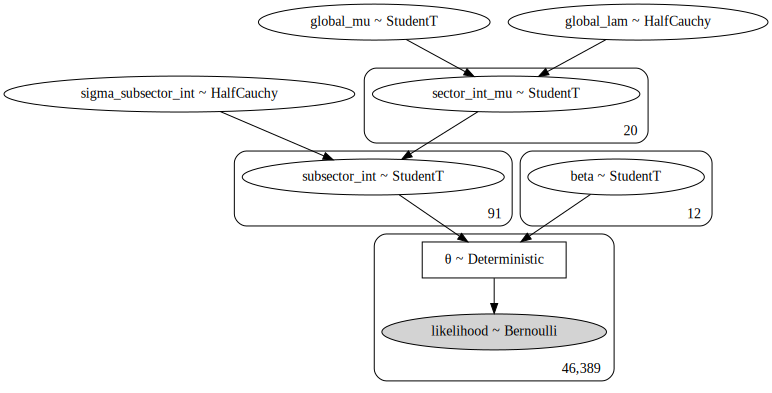

In [169]:
from pymc3 import model_to_graphviz

model_to_graphviz(hierarchical_logistic_osha_2)

In [191]:
with hierarchical_logistic_osha_2:
    fr_advi = pm.FullRankADVI()
tracker = pm.callbacks.Tracker(
    mean=fr_advi.approx.mean.eval,  # callable that returns mean
    std=fr_advi.approx.std.eval  # callable that returns std
)
fit = fr_advi.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4), tracker])

  0%|          | 0/100000 [00:00<?, ?it/s]/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple seq

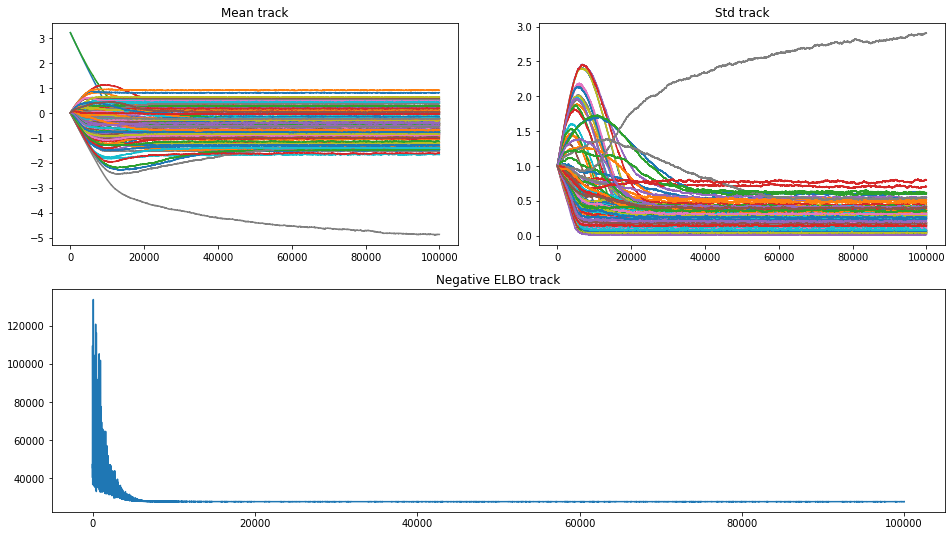

In [193]:
fig = plt.figure(figsize=(16, 9))
mu_ax = fig.add_subplot(221)
std_ax = fig.add_subplot(222)
hist_ax = fig.add_subplot(212)
mu_ax.plot(tracker['mean'])
mu_ax.set_title('Mean track')
std_ax.plot(tracker['std'])
std_ax.set_title('Std track')
hist_ax.plot(fit.hist)
hist_ax.set_title('Negative ELBO track');

<Figure size 432x1152 with 0 Axes>

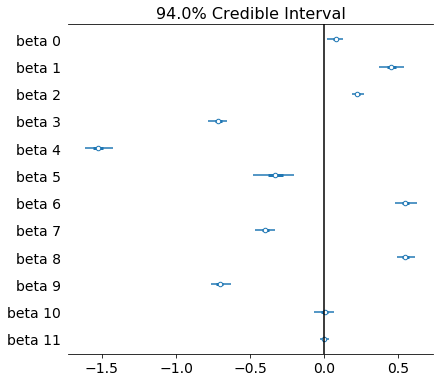

In [194]:
from pymc3 import forestplot
plt.figure(figsize=(6,16))
#forestplot(mean_field.sample(1000), kind='ridgeplot', colors='white', var_names=['beta']);
forestplot(fit.sample(1000), var_names=['beta']);
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


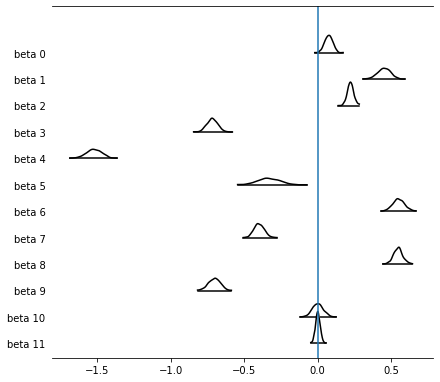

In [195]:
fig, axes = forestplot(fit.sample(1000), kind='ridgeplot', var_names=['beta'], ridgeplot_overlap=3, colors='white');
plt.axvline(x=0)

In [189]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred
beta 1: bioconcentration_factor_opera_pred
beta 2: biodegradation_half_life_days_days_opera_pred
beta 3: boiling_point_degc_opera_pred
beta 4: henrys_law_atm-m3/mole_opera_pred
beta 5: opera_km_days_opera_pred
beta 6: octanol_air_partition_coeff_logkoa_opera_pred
beta 7: soil_adsorption_coefficient_koc_l/kg_opera_pred
beta 8: octanol_water_partition_logp_opera_pred
beta 9: melting_point_degc_opera_pred
beta 10: vapor_pressure_mmhg_opera_pred
beta 11: water_solubility_mol/l_opera_pred


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


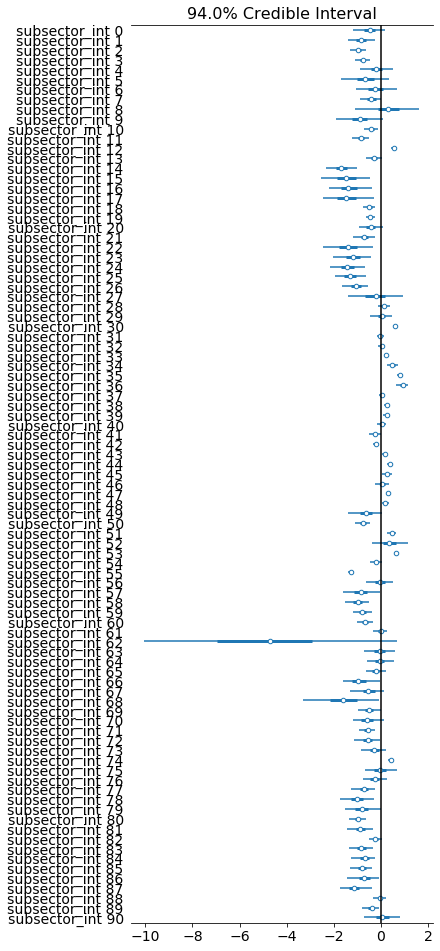

In [198]:
forestplot(fit.sample(1000), var_names=['subsector_int'])
plt.axvline(x=0, color='black')

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


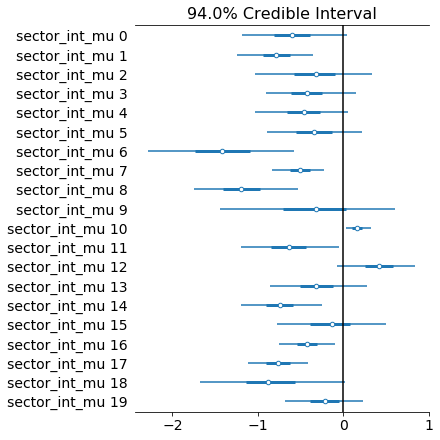

In [199]:
forestplot(fit.sample(1000), var_names=['sector_int_mu']);
plt.axvline(x=0, color='black')

In [187]:
sector_index

,index,sector_name
0,0,Accomodation and Food Services
1,1,Administrative and Support and Waste Managemen...
2,2,"Agriculture, Forestry, Fishing and Hunting"
3,3,"Arts, Entertainment, and Recreation"
4,4,Construction
5,5,Educational Services
6,6,Finance and Insurance
7,7,Health Care and Social Assistance
8,8,Information
9,9,Management of Companies and Enterprises


/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5eef4eb790>,
      dtype=object)

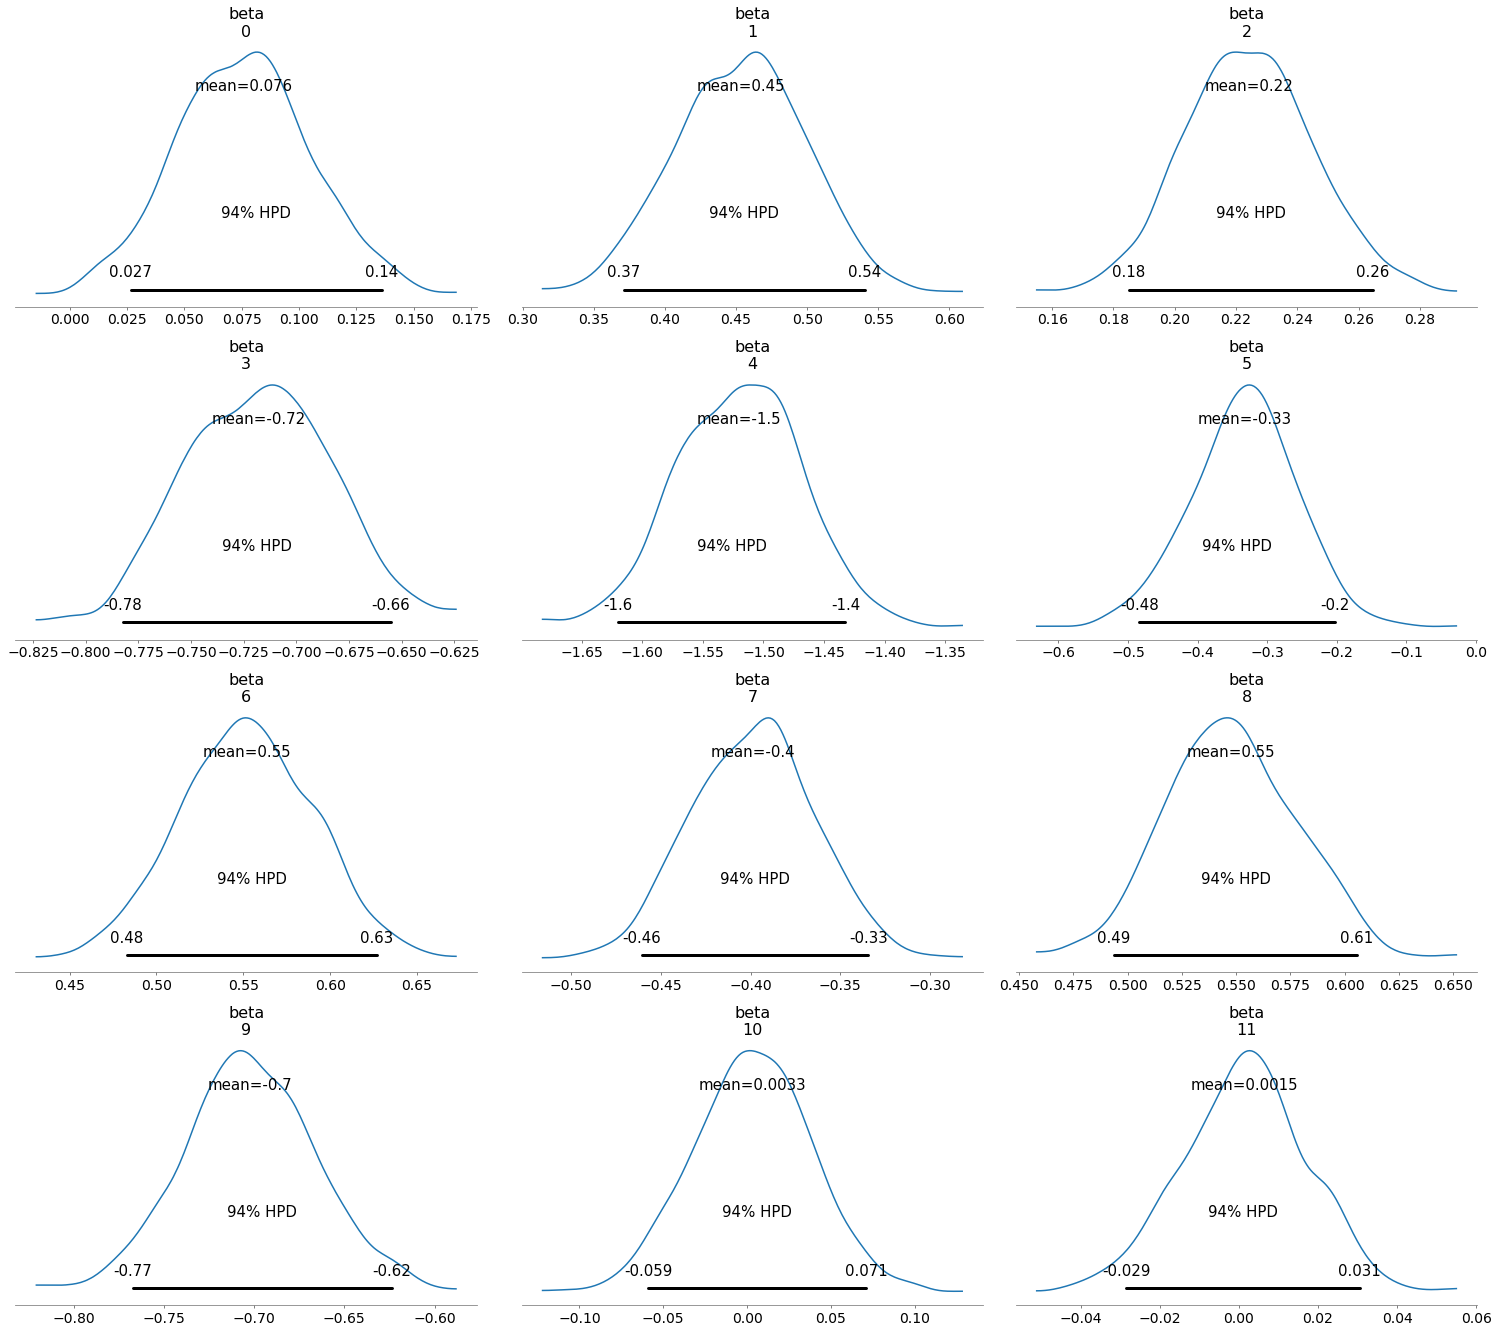

In [200]:
pm.plot_posterior(fit.sample(1000), var_names=['beta'])

In [189]:
for i, var in enumerate(opera_cols):
    print('beta {}: {}'.format(i,var))

beta 0: atmospheric_hydroxylation_rate_(aoh)_cm3/molecule*sec_opera_pred
beta 1: bioconcentration_factor_opera_pred
beta 2: biodegradation_half_life_days_days_opera_pred
beta 3: boiling_point_degc_opera_pred
beta 4: henrys_law_atm-m3/mole_opera_pred
beta 5: opera_km_days_opera_pred
beta 6: octanol_air_partition_coeff_logkoa_opera_pred
beta 7: soil_adsorption_coefficient_koc_l/kg_opera_pred
beta 8: octanol_water_partition_logp_opera_pred
beta 9: melting_point_degc_opera_pred
beta 10: vapor_pressure_mmhg_opera_pred
beta 11: water_solubility_mol/l_opera_pred


### Find an exact solution with Hamiltonian MC (takes longer)

In [134]:
with hierarchical_logistic_osha_2:
    hmc = pm.sample(4000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, subsector_int, sigma_subsector_int, sector_int_mu, global_lam]
Sampling 4 chains: 100%|██████████| 18000/18000 [13:43:40<00:00,  2.75s/draws]
The acceptance probability does not match the target. It is 0.9461170656509861, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The acceptance probability does not match the tar

In [135]:
pm.gelman_rubin(hmc)

{'subsector_int': array([2.97940544e+07, 5.91746569e+07, 5.73184503e+06, 4.39746962e+07,
        6.19347101e+06, 1.93171714e+07, 9.51238468e+07, 1.02301813e+07,
        1.16999401e+07, 1.53962348e+07, 7.44658110e+07, 1.39854757e+07,
        4.45018741e+07, 2.58458412e+07, 4.97914850e+06, 5.39789236e+06,
        1.40559054e+07, 2.63163703e+07, 1.21526110e+07, 4.81274902e+07,
        7.47677166e+07, 8.20838608e+07, 1.19719195e+08, 1.29074992e+07,
        4.13080942e+07, 2.71956595e+07, 4.31031825e+07, 3.68807017e+07,
        2.65517056e+06, 1.07286652e+07, 6.41709069e+07, 7.21276249e+07,
        5.52468125e+06, 1.61372050e+07, 1.00189925e+08, 2.35498826e+07,
        1.78795023e+08, 1.03655499e+07, 2.48742924e+07, 1.09615947e+07,
        3.10142980e+06, 1.31746345e+08, 1.16926057e+07, 3.98130071e+07,
        1.23264897e+08, 2.41648830e+07, 5.30792125e+07, 5.23642046e+07,
        1.62334125e+07, 2.44518589e+07, 1.42714818e+07, 1.82932754e+07,
        8.32426995e+07, 1.17548774e+07, 2.09877

/home/jminucci/anaconda3/envs/occupation/lib/python3.7/site-packages/arviz/plots/traceplot.py:155: SyntaxWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of variables to plot (91), generating only 40 plots
  SyntaxWarning,


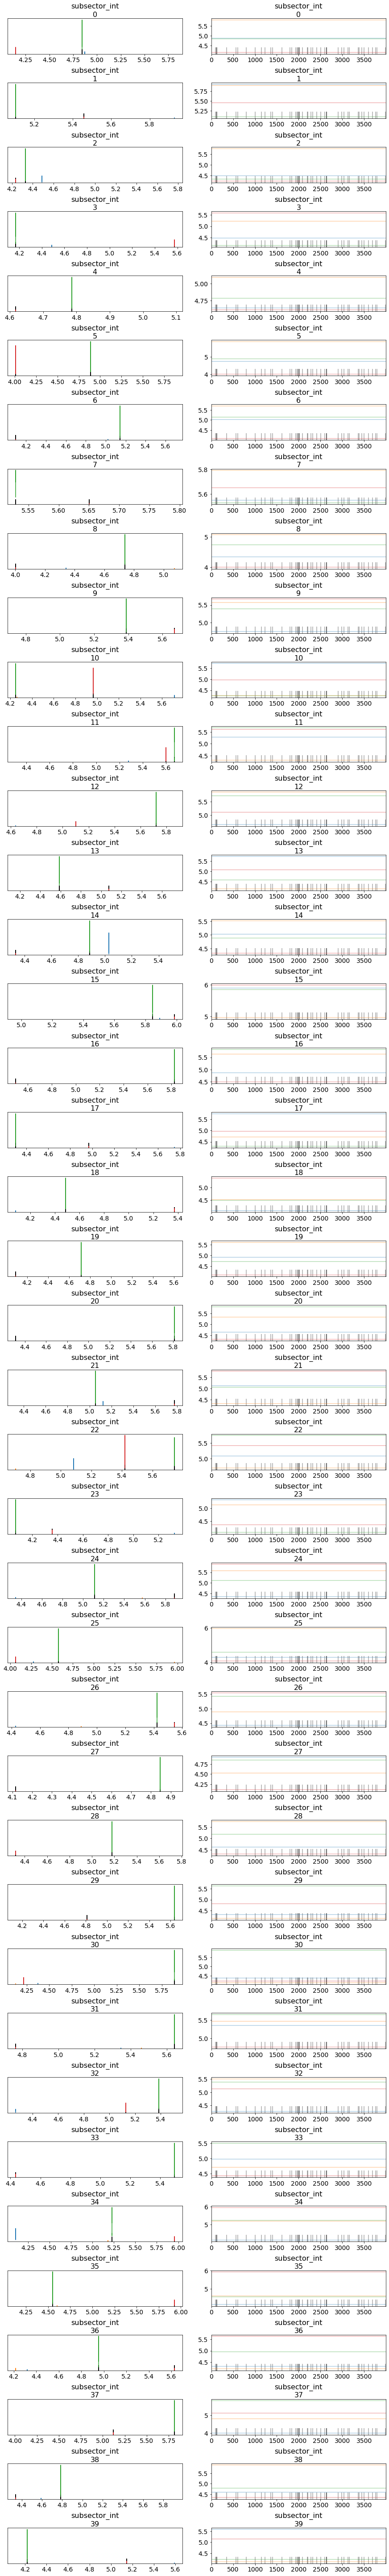

In [136]:
pm.traceplot(hmc, var_names=['subsector_int']);

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5eef4f5a90>,
      dtype=object)

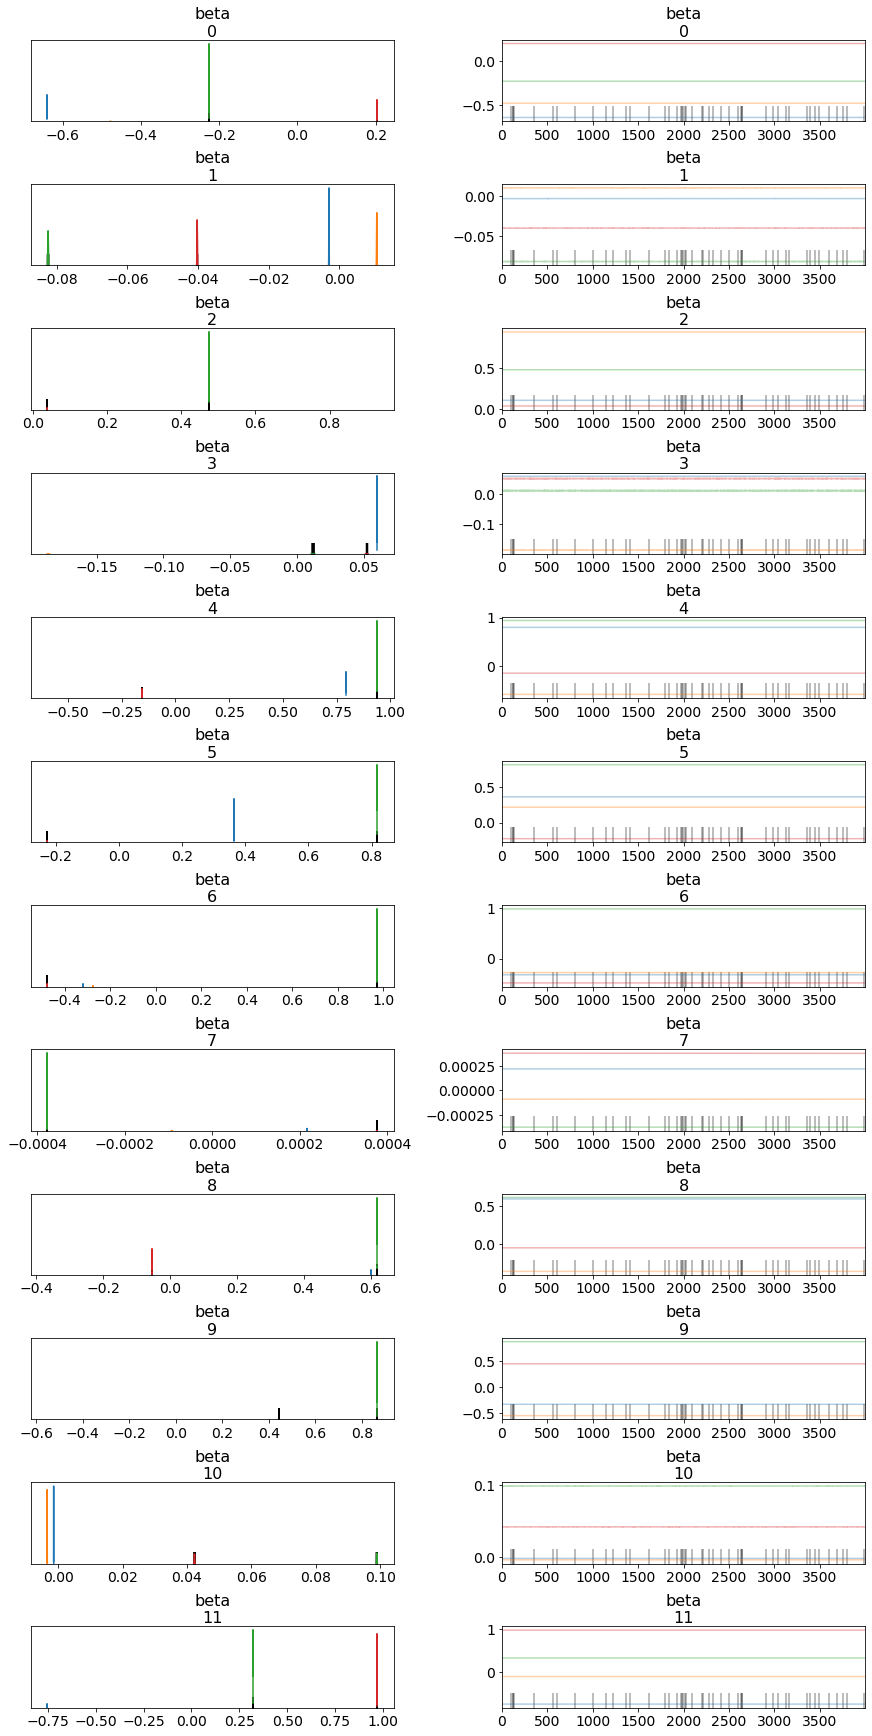

In [137]:
pm.traceplot(hmc,var_names = ['beta'])

(<Figure size 432x1317.6 with 1 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f5ef143ae50>],
       dtype=object))

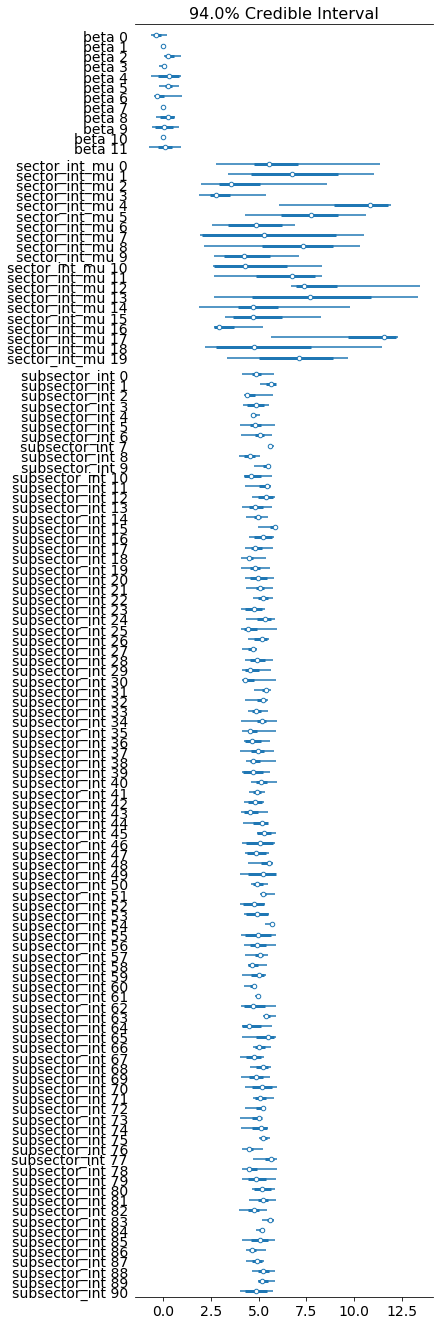

In [138]:
pm.forestplot(hmc, var_names = ['beta','sector_int_mu', 'subsector_int'], combined=True)